In [1]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from fastai.tabular.all import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import time
import sys
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv('all_nona_scale_label.csv')
data = data.drop(['Unnamed: 0'], axis=1)
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [7]:
import pandas as pd
import sys
from scipy import stats  # 导入用于统计计算的模块

# 打印帮助信息
def print_help_info():
    print("""
    Usage: python ANONA.py input_file.csv output_file.csv
    
    Other details, please read the README file!
""")
    exit(0)

# 根据 ANONA 算法生成排序后的 F-value 和 P-value 文件
def generate_ANONA_sorted_file(df, outputfile):
    [F_values, P_values, group_num, sample_num, total_sample, feature_num] = obtain_ANONA_values_dict(df)
    
    # 将 F-values 按值从大到小排序
    F_values = sorted(F_values.items(), key=lambda asd: asd[1], reverse=True)
    # 将 P-values 按值从小到大排序
    P_values = sorted(P_values.items(), key=lambda asd: asd[1])

    # 将排序后的特征、F-value 和 P-value 存储到 pandas DataFrame
    output_df = pd.DataFrame({
        'Feature': [item[0] for item in F_values],
        'F-value': [item[1] for item in F_values],
        'P-value': [P_values[i][1] for i in range(len(P_values))]
    })

    # 将 DataFrame 输出为 CSV 文件
    output_df.to_csv(outputfile, index=False)
    print(f"Output successfully saved to {outputfile}")

# 获取 ANONA 算法所需的各个值（如 F-values, P-values, 样本数量等）
def obtain_ANONA_values_dict(df):
    # 提取列名（去掉第一列作为标签列）
    note_label = df.columns[1:].tolist()  # 假设第一列是标签列
    key_words = df.iloc[:, 0].tolist()  # 获取第一列（类别标签）

    # 将数据按类别进行分组，并存储
    csv_dics = {}
    for label in df.iloc[:, 0].unique():  # 获取所有唯一的标签
        csv_dics[label] = df[df.iloc[:, 0] == label].iloc[:, 1:].values.tolist()  # 按标签筛选数据并存储

    feature_num = len(note_label)  # 特征数为列数减去标签列

    F_values = {}  # 存储各特征的 F-value
    P_values = {}  # 存储各特征的 P-value
    group_num, sample_num, total_sample = get_sample_num(key_words)  # 获取各个标签的样本数量

    # 对每个标签计算 F-value 和 P-value
    for label_index in range(len(note_label)):
        label = note_label[label_index]

        assign_label_values = get_assign_label_values(csv_dics, label_index)  # 获取每个标签对应的值

        # 计算 F-value
        F_values[label] = calculate_thisLabel_Fvalue(assign_label_values, group_num, sample_num, total_sample)

        # 计算 P-value
        P_values[label] = calculate_p_value(csv_dics, label_index)  # 使用 ANOVA 方法计算 P 值

    return F_values, P_values, group_num, sample_num, total_sample, feature_num

# 计算每个特征的 P 值（使用单因素方差分析）
def calculate_p_value(csv_dics, label_index):
    data_groups = []  # 存储每个标签的样本值

    for each_class in csv_dics.keys():
        content = []
        key_values = csv_dics[each_class]
        for each_values_index in range(len(key_values)):
            content.append(float(key_values[each_values_index][label_index]))  # 获取该特征值
        data_groups.append(content)  # 存储该类的特征值

    # 使用单因素方差分析计算 P 值
    F_stat, p_value = stats.f_oneway(*data_groups)
    return p_value

# 获取样本的数量，包括每个类别的样本数量及总样本数
def get_sample_num(key_words):
    sample_num = {}  # 每个类别的样本数量
    total_sample = 0  # 总样本数

    key_words_set = set(key_words)  # 获取所有不同的标签
    group_num = len(key_words_set)  # 标签的类别数
    for each in key_words_set:
        assign_sample_num = key_words.count(each)  # 计算某个标签的样本数量
        sample_num[each] = assign_sample_num
        total_sample += assign_sample_num  # 累加总样本数

    return group_num, sample_num, total_sample

# 获取每个标签对应的特征值
def get_assign_label_values(csv_dics, label_index):
    assign_label_values = {}

    for each_class in csv_dics.keys():  # 遍历每个标签
        content = []
        key_values = csv_dics[each_class]  # 获取该标签对应的所有特征值
        for each_values_index in range(len(key_values)):
            content.append(float(key_values[each_values_index][label_index]))  # 获取该特征值
        assign_label_values[each_class] = content  # 存储每个标签对应的特征值

    return assign_label_values

# 计算某个标签的 F-value
def calculate_thisLabel_Fvalue(assign_label_values, group_num, sample_num, total_sample):
    if group_num == 1 or total_sample == group_num:  # 如果标签种类太少，则无法计算 F-value
        print("Warning: Group number or total sample number is too small for F-value calculation.")
        return 0  # 返回默认值或根据需要返回其他值

    [within_group_mean, total_mean] = calculate_withinGroup_and_total_mean(assign_label_values, sample_num, total_sample)

    # 计算组间平方和 SSb
    SSb = 0
    for each_assign_label in within_group_mean.keys():
        SSb += (((within_group_mean[each_assign_label] - total_mean) ** 2) * sample_num[each_assign_label])

    # 计算组内平方和 SSw
    SSw = calculate_SumOfSquaresWithinGroups(assign_label_values, within_group_mean)

    if SSw == 0:  # 如果组内平方和为零，F-value无法计算
        print("Warning: Sum of Squares Within Groups is zero.")
        return 0

    # 计算 F-value
    Fvalue = (SSb / (group_num - 1)) / (SSw / (total_sample - group_num))
    return Fvalue

# 计算组内均值和总均值
def calculate_withinGroup_and_total_mean(assign_label_values, sample_num, total_sample):
    within_group_mean = {}  # 存储每个组内的均值
    summary = 0  # 总和

    for each_group_label in assign_label_values.keys():  # 遍历每个组
        each_group_summary = sum(assign_label_values[each_group_label])  # 计算该组的总和

        within_group_mean[each_group_label] = each_group_summary / sample_num[each_group_label]  # 计算均值
        summary += each_group_summary  # 累加总和

    total_mean = summary / total_sample  # 计算总体均值

    return within_group_mean, total_mean

# 计算组内平方和
def calculate_SumOfSquaresWithinGroups(assign_label_values, within_group_mean):
    value = 0  # 初始化平方和

    for each_assign_label in assign_label_values.keys():  # 遍历每个标签
        for each_value in assign_label_values[each_assign_label]:  # 遍历每个特征值
            value += ((each_value - within_group_mean[each_assign_label]) ** 2)  # 累加平方和

    return value

# 输出数据统计信息
def get_output_prompt(group_num, sample_num, total_sample, feature_num):
    content = 'There is a %d classification problem!\n\tTotal sample numbers : %d\n\tTotal feature numbers : %d\n\n' \
              % (group_num, total_sample, feature_num)

    for each in sample_num.keys():
        content += '\t\tThe sample numbers of label \'%s\' : %d\n' % (each, sample_num[each])
    content += '\n'

    return content

# 读取 CSV 文件并运行主程序
if __name__ == '__main__':
    try:
        # 使用 pandas 读取 CSV 文件（`data` 是读取的 CSV 文件数据，假设已经定义）
        df = data

        # 设置输出文件路径
        outputfile = "D:\\KY\\multi_omics_SZ\\1.csv"

        # 生成 ANONA 排序后的文件
        generate_ANONA_sorted_file(df, outputfile)

    except Exception as e:
        print(f"An error occurred: {e}")


Output successfully saved to D:\KY\multi_omics_SZ\1.csv


In [34]:
import lightgbm as lgb
import os
import sys

In [35]:
# 检查 Python 版本并输出帮助信息
def detectingPythonVersionAndOutputHelpInfo():
    if sys.version[0] == '2':
        print("""\nVersionError: 当前 Python 版本: '%s'，你必须使用 Python 3 或更高版本来运行此脚本！\n""" % (sys.version).split('\n')[0])
        exit(0)
    else:
        pass

    try:
        if sys.argv[1] == "--help":
            printHelpInfo()
        else:
            pass
    except:
        printHelpInfo()

In [36]:
# 读取 mRMR 排序的特征文件
def obatinMrmrSortedFeatureNamesList(mrmrSortedFile):
    featureNames = []
    judge = False

    with open(mrmrSortedFile) as f:
        for eachline in f:
            if "mRMR features" in eachline:
                judge = True
                continue
            if judge:
                if eachline == "\n":
                    break
                if not eachline[0].isdigit():
                    continue
                featureNames.append(eachline.split("\t")[2].strip(" "))

    return featureNames

In [46]:
# 生成 LightGBM 格式的文件
def generateLightGBMFileOfSortedFeatures(inCsvFile, mrmrSortedFile):
    outputFilename = os.path.splitext(inCsvFile)[0] + "_LightGBMSorted.txt"
    sortedFeatureList = obatinMrmrSortedFeatureNamesList(mrmrSortedFile)

    with open(outputFilename, 'w') as g, open(inCsvFile) as f:
        countLine = 0
        for eachline in f:
            countLine += 1
            temp = eachline.strip().split(",")
            if countLine == 1:
                featureNames = temp[1:]  # 第一行是特征名，跳过
                continue

            outStr = "%s" % temp[0]  # 第一列为标签
            valueNames = temp[1:]

            countNum = 0
            for eachFea in sortedFeatureList:
                countNum += 1
                feaValue = valueNames[featureNames.index(eachFea)]
                outStr += ' %d:%s' % (countNum, feaValue)  # 格式为 FeatureIndex:FeatureValue
            g.write(outStr + '\n')

    print("\n---完成!---\n结果已保存到文件: %s" % outputFilename)

In [44]:
# 预测函数：使用 AutoGluon 加载模型并进行预测
def predictWithAutoGluon(model_path, data_path):
    # 加载已经训练的 AutoGluon 模型
    predictor = TabularPredictor.load(model_path)

    # 加载待预测的数据（确保数据是 pandas DataFrame 格式）
    test_data = pd.read_csv(data_path)  # 读取 CSV 文件为 DataFrame

    # 使用加载的模型进行预测
    predictions = predictor.predict(test_data)  # 直接传入 DataFrame
    return predictions
#predictor = TabularPredictor.load(r"AutogluonModels\ag-20241103_082447") 
#predictions = predictor.predict(test_data)

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.feature_selection import f_classif

def mrmr_feature_selection(data, target_column, top_k_features=20):
    # 确保目标列和特征列分开
    features = data.drop(columns=[target_column])  # 删除目标列，得到特征
    target = data[target_column]  # 获取目标列
    
    # 计算每个特征与目标变量的皮尔逊相关系数（最大相关性）
    correlation_with_target = features.corrwith(target).abs()

    # 计算每个特征与目标的p-value（显著性评价）
    _, p_values = f_classif(features, target)
    
    # 计算每个特征与目标之间的相关性和显著性，存储成DataFrame
    feature_importance = pd.DataFrame({
        'Feature': correlation_with_target.index,
        'MRMR Score': correlation_with_target.values,
        'p-value': p_values
    })

    # 按照 MRMR Score 排序，选择前 top_k_features 个特征
    feature_importance = feature_importance.sort_values(by='MRMR Score', ascending=False)
    
    # 选择前 top_k_features 个特征
    top_features = feature_importance.head(top_k_features)

    # 保存为 CSV 文件
    top_features.to_csv('mrmr_top_20_features.csv', index=False)

    return top_features

# 主函数
if __name__ == '__main__':
    # 加载数据
    data = pd.read_csv('all_nona_scale_label.csv')
    data = data.drop(['Unnamed: 0'], axis=1)

    # 目标列是你要预测的列（比如 'label'），调整为你的数据集中的实际目标列名
    target_column = 'label'

    # 获取最重要的前 20 个特征
    top_features = mrmr_feature_selection(data, target_column, top_k_features=20)

    # 输出最重要的特征及其 MRMR 评分和显著性
    print("Top 20 Features selected by mRMR:")
    print(top_features)

Top 20 Features selected by mRMR:
      Feature  MRMR Score       p-value
1123   ptm382    0.562186  5.299340e-10
1117   ptm376    0.517912  1.797214e-08
757     ptm16    0.495374  8.980742e-08
1118   ptm377    0.493499  1.021395e-07
771     ptm30    0.490438  1.258117e-07
1122   ptm381    0.479280  2.644458e-07
803     ptm62    0.476493  3.170625e-07
1126   ptm385    0.474915  3.511091e-07
3000  ptm2634    0.470892  4.543927e-07
2846  ptm2480    0.469410  4.992399e-07
746      ptm5    0.468239  5.376399e-07
773     ptm32    0.468148  5.407367e-07
1127   ptm386    0.465647  6.328409e-07
759     ptm18    0.462651  7.627792e-07
2786  ptm2420    0.460225  8.861383e-07
106    Q15166    0.458463  9.873802e-07
1133   ptm392    0.455367  1.192295e-06
1113   ptm372    0.454398  1.264329e-06
758     ptm17    0.449477  1.698263e-06
1080   ptm339    0.446007  2.085401e-06


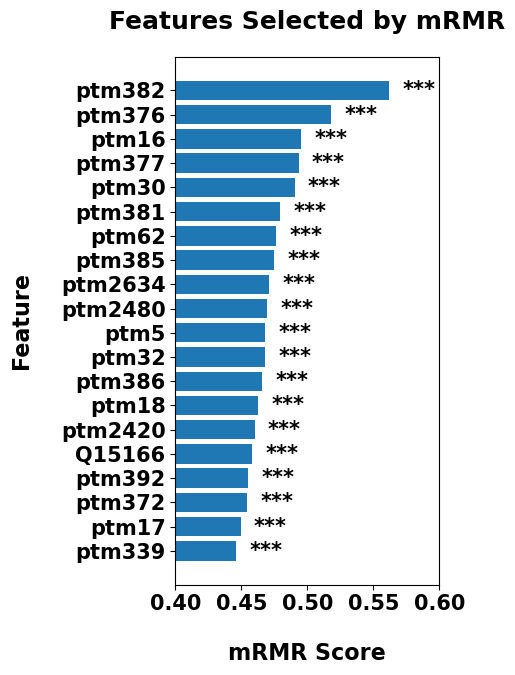

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance_with_significance(top_features, width=10, height=6):
    # 设置全局字体大小
    plt.rcParams.update({'font.size': 15})  # 这里设置所有字体的大小
    
    # 按照 MRMR Score 排序
    top_features = top_features.sort_values(by='MRMR Score', ascending=True)
    
    # 创建柱状图，并调整图表的大小
    plt.figure(figsize=(width, height))
    bars = plt.barh(top_features['Feature'], top_features['MRMR Score'], color='#1f77b4')

    # 添加 P 值符号
    for i, (score, p_value) in enumerate(zip(top_features['MRMR Score'], top_features['p-value'])):
        # 根据 p 值添加不同数量的星号
        if p_value < 0.01:
            p_significance = '***'
        elif p_value < 0.05:
            p_significance = '**'
        elif p_value < 0.1:
            p_significance = '*'
        else:
            p_significance = 'ns'  # 非显著性

        # 显示 p 值符号，添加到柱子右侧
        plt.text(score + 0.01, i, f'{p_significance}', va='center', color='black')
    
    # 添加图表标题和标签
    plt.title('Features Selected by mRMR', fontsize=18, pad=20)
    plt.xlabel('mRMR Score', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    
    # 设置横坐标刻度范围
    plt.xlim(0.4, 0.6)

    # 设置 y 轴标签与坐标轴之间的距离
    plt.gca().yaxis.labelpad = 20  # 调整 'Feature' 标签与坐标轴的距离
    plt.gca().xaxis.labelpad = 20  # 调整 'Feature' 标签与坐标轴的距离

    # 显示图表
    plt.tight_layout()
    plt.savefig(f"mrmr_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

# 主函数
if __name__ == '__main__':
    # 加载数据
    data = pd.read_csv('all_nona_scale_label.csv')
    data = data.drop(['Unnamed: 0'], axis=1)

    # 目标列是你要预测的列（比如 'label'），调整为你的数据集中的实际目标列名
    target_column = 'label'

    # 获取最重要的前 20 个特征
    top_features = mrmr_feature_selection(data, target_column, top_k_features=20)

    # 绘制包含显著性分析的柱状图，调整宽高
    plot_feature_importance_with_significance(top_features, width=5, height=7)  # 这里调整宽度和高度


In [13]:
from sklearn.feature_selection import f_classif
import pandas as pd

def fscore_feature_selection(data, target_column, top_k_features=20):
    # 确保目标列和特征列分开
    features = data.drop(columns=[target_column])  # 删除目标列，得到特征
    target = data[target_column]  # 获取目标列
    
    # 使用 ANOVA F-test 来计算每个特征的 F-score 和 p-value
    f_scores, p_values = f_classif(features, target)
    
    # 将 F-score 和 p-value 与特征名结合起来
    feature_fscore = pd.Series(f_scores, index=features.columns)
    feature_pvalues = pd.Series(p_values, index=features.columns)
    
    # 创建一个 DataFrame 存储特征、F-score 和显著性 p-value
    feature_info = pd.DataFrame({
        'Feature': features.columns,
        'F-score': feature_fscore.values,
        'p-value': feature_pvalues.values
    })

    # 按照 F-score 从高到低排序，并选择前 top_k_features 个特征
    feature_info_sorted = feature_info.sort_values(by='F-score', ascending=False).head(top_k_features)

    return feature_info_sorted

# 主函数
if __name__ == '__main__':
    # 加载数据
    data = pd.read_csv('all_nona_scale_label.csv')
    data = data.drop(['Unnamed: 0'], axis=1)

    # 目标列是你要预测的列（比如 'label'），调整为你的数据集中的实际目标列名
    target_column = 'label'

    # 获取最重要的前 20 个特征及其 F-score 和 p-value
    top_features = fscore_feature_selection(data, target_column, top_k_features=20)

    # 将结果保存为 CSV 文件
    top_features.to_csv('fscore_top_20_features.csv', index=False)

    # 输出最重要的特征及其 F-score 和 p-value
    print("Top 20 Features selected by F-score and their p-values:")
    print(top_features)


Top 20 Features selected by F-score and their p-values:
      Feature    F-score       p-value
1123   ptm382  47.134373  5.299340e-10
1117   ptm376  37.388593  1.797214e-08
757     ptm16  33.170125  8.980742e-08
1118   ptm377  32.838855  1.021395e-07
771     ptm30  32.304109  1.258117e-07
1122   ptm381  30.417526  2.644458e-07
803     ptm62  29.961194  3.170625e-07
1126   ptm385  29.705472  3.511091e-07
3000  ptm2634  29.061460  4.543927e-07
2846  ptm2480  28.827273  4.992399e-07
746      ptm5  28.643237  5.376399e-07
773     ptm32  28.628985  5.407367e-07
1127   ptm386  28.239378  6.328409e-07
759     ptm18  27.778507  7.627792e-07
2786  ptm2420  27.409912  8.861383e-07
106    Q15166  27.144650  9.873802e-07
1133   ptm392  26.683744  1.192295e-06
1113   ptm372  26.540757  1.264329e-06
758     ptm17  25.824315  1.698263e-06
1080   ptm339  25.328426  2.085401e-06


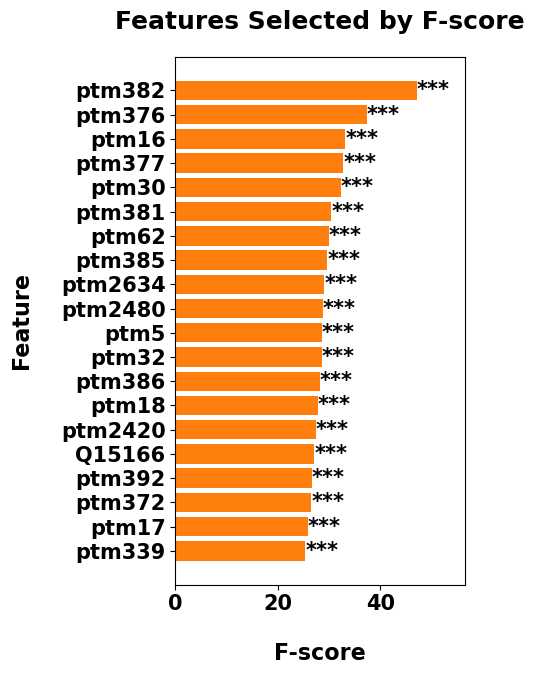

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 12,          # 全局字体大小
    'font.weight': 'bold',    # 全局字体加粗
    'axes.labelweight': 'bold',  # 坐标轴标签加粗
    'axes.titleweight': 'bold'   # 标题加粗（如果有）
})

def plot_feature_importance_with_significance(top_features, width=10, height=6):
    # 设置全局字体大小
    plt.rcParams.update({'font.size': 15})  # 这里设置所有字体的大小
    
    # 按照 F-score 排序
    top_features = top_features.sort_values(by='F-score', ascending=True)
    
    # 创建柱状图，并调整图表的大小
    plt.figure(figsize=(width, height))
    bars = plt.barh(top_features['Feature'], top_features['F-score'], color='#ff7f0e')

    # 添加 P 值符号
    for i, (score, p_value) in enumerate(zip(top_features['F-score'], top_features['p-value'])):
        # 根据 p 值添加不同数量的星号
        if p_value < 0.01:
            p_significance = '***'
        elif p_value < 0.05:
            p_significance = '**'
        elif p_value < 0.1:
            p_significance = '*'
        else:
            p_significance = 'ns'  # 非显著性

        # 显示 p 值符号，添加到柱子右侧
        plt.text(score + 0.01, i, f'{p_significance}', va='center', color='black')
    
    # 添加图表标题和标签
    plt.title('Features Selected by F-score', fontsize=18, pad=20)
    plt.xlabel('F-score', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    
    # 设置横坐标刻度范围
    plt.xlim(0, max(top_features['F-score']) * 1.2)  # 自动扩展范围

    # 设置 y 轴标签与坐标轴之间的距离
    plt.gca().yaxis.labelpad = 20  # 调整 'Feature' 标签与坐标轴的距离
    plt.gca().xaxis.labelpad = 20  # 调整 'Feature' 标签与坐标轴的距离

    # 显示图表
    plt.tight_layout()
    plt.savefig(f"fscore_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

# 主函数
if __name__ == '__main__':
    # 加载数据
    data = pd.read_csv('all_nona_scale_label.csv')
    data = data.drop(['Unnamed: 0'], axis=1)

    # 目标列是你要预测的列（比如 'label'），调整为你的数据集中的实际目标列名
    target_column = 'label'

    # 获取最重要的前 20 个特征
    top_features = fscore_feature_selection(data, target_column, top_k_features=20)

    # 绘制包含显著性分析的柱状图，调整宽高
    plot_feature_importance_with_significance(top_features, width=5, height=7)  # 这里调整宽度和高度


In [ ]:
def plot_feature_importance_with_significance(top_features, width=10, height=6):
    # 设置全局字体大小
    plt.rcParams.update({'font.size': 15})  # 这里设置所有字体的大小
    
    # 按照 F-score 排序
    top_features = top_features.sort_values(by='F-value', ascending=True)
    
    # 创建柱状图，并调整图表的大小
    plt.figure(figsize=(width, height))
    bars = plt.barh(top_features['Feature'], top_features['F-value'], color='#9467bd')

    # 添加 P 值符号
    for i, (score, p_value) in enumerate(zip(top_features['F-value'], top_features['p-value'])):
        # 根据 p 值添加不同数量的星号
        if p_value < 0.01:
            p_significance = '***'
        elif p_value < 0.05:
            p_significance = '**'
        elif p_value < 0.1:
            p_significance = '*'
        else:
            p_significance = 'ns'  # 非显著性

        # 显示 p 值符号，添加到柱子右侧
        plt.text(score + 0.01, i, f'{p_significance}', va='center', color='black')
    
    # 添加图表标题和标签
    plt.title('Features Selected by ANOVA', fontsize=14)
    plt.xlabel('ANOVA', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    
    # 设置横坐标刻度范围
    plt.xlim(0, max(top_features['F-value']) * 1.1)  # 自动扩展范围

    # 设置 y 轴标签与坐标轴之间的距离
    plt.gca().yaxis.labelpad = 20  # 调整 'Feature' 标签与坐标轴的距离
    plt.gca().xaxis.labelpad = 20  # 调整 'Feature' 标签与坐标轴的距离

    # 显示图表
    plt.tight_layout()
    plt.savefig(f"anova_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

# 主函数
if __name__ == '__main__':
    # 加载数据
    data = pd.read_csv('all_nona_scale_label.csv')
    data = data.drop(['Unnamed: 0'], axis=1)

    # 目标列是你要预测的列（比如 'label'），调整为你的数据集中的实际目标列名
    target_column = 'label'

    # 获取最重要的前 20 个特征
    top_features = fscore_feature_selection(data, target_column, top_k_features=20)

    # 绘制包含显著性分析的柱状图，调整宽高
    plot_feature_importance_with_significance(top_features, width=5, height=7)  # 这里调整宽度和高度


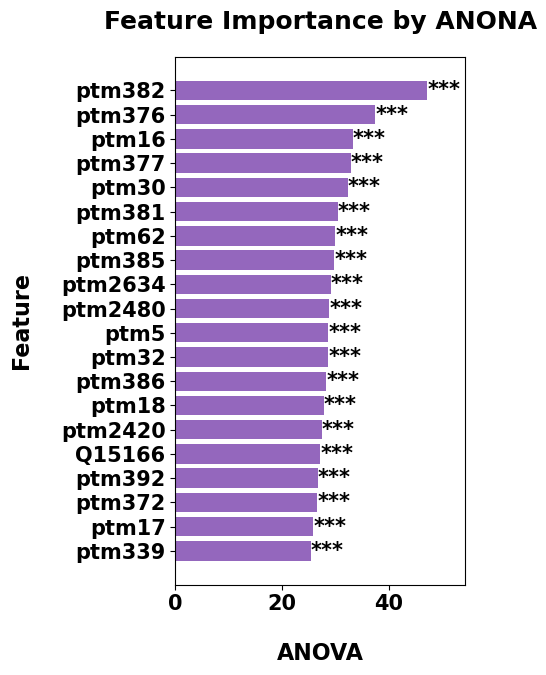

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 12,          # 全局字体大小
    'font.weight': 'bold',    # 全局字体加粗
    'axes.labelweight': 'bold',  # 坐标轴标签加粗
    'axes.titleweight': 'bold'   # 标题加粗（如果有）
})

def plot_ANONA_feature_importance(top_features, width=10, height=6):
    # 设置全局字体大小
    plt.rcParams.update({'font.size': 15})
    
    # 按F-value降序排序，确保最高值在顶部
    top_features = top_features.sort_values(by='F-value', ascending=True)  # 水平条形图需要升序显示
    
    # 创建图表
    plt.figure(figsize=(width, height))
    bars = plt.barh(top_features['Feature'], top_features['F-value'], color='#9467bd')

    # 添加P值显著性标记
    for i, (f_value, p_value) in enumerate(zip(top_features['F-value'], top_features['P-value'])):
        if p_value < 0.001:
            p_sig = '***'
        elif p_value < 0.01:
            p_sig = '**'
        elif p_value < 0.05:
            p_sig = '*'
        else:
            p_sig = 'ns'
        
        # 在柱子右侧添加标记
        plt.text(f_value + 0.01, i, p_sig, va='center', color='black')

    # 设置标题和标签
    plt.title('Feature Importance by ANONA', fontsize=18, pad=20)
    plt.xlabel('ANOVA', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    
    # 调整坐标轴间距
    plt.gca().yaxis.labelpad = 20
    plt.gca().xaxis.labelpad = 20

    # 自动调整坐标轴范围，或根据数据设置合适的范围
    plt.xlim(0, top_features['F-value'].max() * 1.15)  # 自动扩展15%空间
    
    # 保存并显示
    plt.tight_layout()
    plt.savefig("anova_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

# 主函数示例
if __name__ == '__main__':
    # 加载ANONA输出的CSV文件（假设列名为Feature, F-value, P-value）
    anona_results = pd.read_csv("D:\\KY\\multi_omics_SZ\\1.csv")
    
    # 选择Top N特征（例如前20）
    top_n = 20
    top_features = anona_results.nlargest(top_n, 'F-value')  # 选择F值最大的前N个特征
    
    # 绘制图表
    plot_ANONA_feature_importance(top_features, width=5, height=7)